# Prototype notebook to reconstruct all PETRIC data

## Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR #the main reconstructor
import scipy.ndimage as ndi # used to do some processing on the images
STIR.AcquisitionData.set_storage_scheme('memory')

In [2]:
# path of the folder containing all the needed input data
data_path = '/mnt/share/petric/Siemens_mMR_NEMA_IQ'

In [3]:
STIR.set_verbosity(1)

## Manual re-implementation of the computation of the Relative difference prior

The gradient is not needed unless the image is allowed to contain negative numbers

At the moment I cannot find a way to computed the step size directly in STIR (could be quite useful)

### Gradient calculation

In [4]:
def rdp_grad (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) \
                /(np.abs(inpImm_)+ np.abs(shiftImm_) + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    


### RDP hess Diag

In [5]:
def rdp_hess_diag (inpImm_,kappa_,eps_,beta_,pixS_):
    inpImm_ = ndi.gaussian_filter(inpImm_,1.3)
    rdpG_ = np.zeros_like(inpImm_)
      
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
          #          print('continuing')
                    continue
                eDist = pixS_[1]/ np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]     
                rdpG_ += (eDist*2)*(kappa_*sk_)*(eps_ +2 * shiftImm_)**2 /(inpImm_+ shiftImm_ + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 3 
                
    rdpG_ *= beta_
    rdpG_ = ndi.gaussian_filter(rdpG_,0.6)
    return rdpG_

### Step size calculation

In [6]:
def rdp_step_size (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    ssNum = 0
    ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
                ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
    return ssNum,ssDen

### Value calculation (not often needed)

In [7]:
def rdp_value (inpImm_,kappa_,eps_,pixS_):
    val=0
    valNP = np.zeros(inpImm_.shape)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
               #     print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))    
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]  
                    sk_[-1,:,:] = kappa_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    sk_[0,:,:] = kappa_[0,:,:]
                wI = 1/(np.abs(inpImm_) + np.abs(shiftImm_)  + 2 * np.abs(inpImm_-shiftImm_) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                #valNP += 0.5* (inpImm_-shiftImm_)**2 * wI
        
                val += np.sum(np.sum(np.sum(0.5* (inpImm_-shiftImm_)**2 * wI ,axis=-1),axis=-1),axis=-1)
    return val

# STIR Setup

Load the image, smooth it lightly, and zero it when its value is low (hopefully it speeds up convergence?)

Also loads the reference image to plot convergence later

In [8]:
image = STIR.ImageData(os.path.join(data_path, 'OSEM_image.hv'))
inpImage = image.as_array()
#inpImage = ndi.gaussian_filter(inpImage,0.75)
penEps = inpImage.max()*1e-3


refImm = STIR.ImageData('/workdir/refs/nema_mMR/reference_image.hv')

In [9]:
kappa = STIR.ImageData(os.path.join(data_path, 'kappa.hv'))

## Set up the relative difference prior computed by STIR

In [184]:
stir_prior = STIR.CudaRelativeDifferencePrior()


In [196]:
stir_prior.set_epsilon(image.max()*1e-3)
stir_prior.set_penalisation_factor(0.0008) #1/700)
stir_prior.set_kappa(kappa)
stir_prior.set_up(image)

## Set up the acquisition model

1. Read the sinogram, the starting image and the corrections. Set them upn in an acquisitionModel
2. To compute the step size, define a model without additive corrections. If one declares an independent one, it duplicate memory use. By using get_linear_acquisition_model() RAM is not wasted


In [216]:
acq_model = STIR.AcquisitionModelUsingParallelproj()
template = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'))
multCorr = STIR.AcquisitionData(os.path.join(data_path,'mult_factors.hs'))
addCorr = STIR.AcquisitionData(os.path.join(data_path,'additive_term.hs'))

rMax = addCorr.max()*1e-6
addCorr +=rMax
addCorr2 = addCorr.clone()
acq_model.set_acquisition_sensitivity(STIR.AcquisitionSensitivityModel(multCorr))
acq_model.set_additive_term(addCorr)
acq_model.set_up(template, image)
ss_model = acq_model.get_linear_acquisition_model()

In [217]:
addCorr2 *= multCorr
addCorr2 += rMax

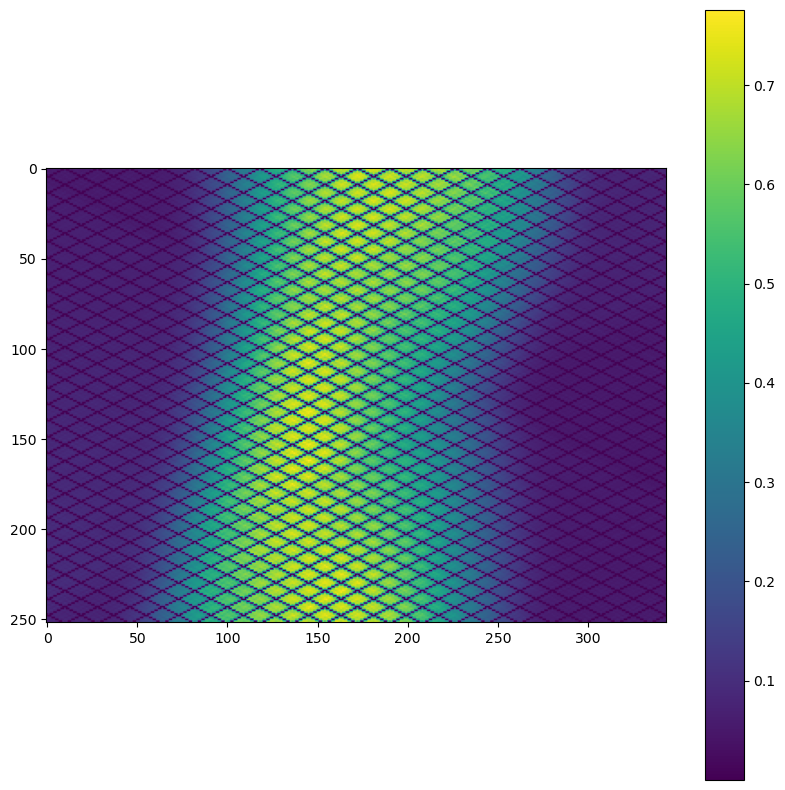

In [221]:
plt.figure(figsize=(10,10))
plt.imshow(addCorr2.as_array()[0,60,:,:])
plt.colorbar()

In [48]:
help(ll.multiply_with_Hessian)

Help on method multiply_with_Hessian in module sirf.STIR:

multiply_with_Hessian(current_estimate, input_, subset=-1, out=None) method of sirf.STIR.PoissonLogLikelihoodWithLinearModelForMeanAndProjData instance
    Computes the multiplication of the Hessian at current_estimate with a vector.



# My Kappa

In [12]:
tImmArrSm = ndi.gaussian_filter(inpImage,0.8)
image.fill(tImmArrSm)

ybar = acq_model.forward(image)

In [13]:
kappa = acq_model.backward(ybar.get_uniform_copy(1))

In [14]:
newKappa = kappa
newKarr = newKappa.as_array()
newKprof = np.mean(np.mean(newKarr,axis=2),axis=1)
nz = image.dimensions()[0]
zv = np.arange(-(nz-1)/2,(nz+1)/2)
zv = np.abs(zv)
zv[zv<0.5]=0.5
zv = 0.5 + 0.5*( 1-zv/((nz-1)/2))
zv = zv.reshape((nz,1,1))
newKprof = newKprof.reshape((nz,1,1))
zv = zv/newKprof
newKarr = newKarr*zv
kernel = np.ones((3,))/3
newKarr = ndi.convolve1d(newKarr,kernel,axis=0,mode='constant')
newKarr *=4.4
newKarr *=100
newKarr *=700
newKarr = np.sqrt(newKarr)

In [15]:
kappa.fill(newKarr)

# Test likelihood


In [95]:
ll = STIR.make_Poisson_loglikelihood(template,acq_model=acq_model)
ll.set_up(image)
#import time
ts = time.time()
hM = ll.multiply_with_Hessian(image,image.get_uniform_copy(1))
print(time.time()-ts)
newFP = acq_model.forward(image)
aaa = acq_model.backward((template/newFP)*(acq_model.get_linear_acquisition_model().forward(image.get_uniform_copy(1))/newFP))

3.0246787071228027


In [109]:
ts = time.time()
aaa = stir_prior.multiply_with_Hessian(image,image.get_uniform_copy(1))
print(ts-time.time())

-1.118504524230957


In [499]:
def rdp_den_exact (inpImm_,sDir_,kappa_,eps_,pixS_,beta_=1/700,alpha_=0):
          
    ssDen = 0
    

    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0):                
                    continue
                eDist = pixS_[1]/ np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))                         
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                

                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + 2 * np.abs(inpImm_-shiftImm_) + eps_)**3
                wI *= (kappa_*sk_ )
                wI *= ((2*shiftImm_+eps_)**2 *  sDir_**2 -(2*inpImm_+eps_)*(2*shiftImm_+eps_)*sDir_*shiftSI_)
                
                ssDen += np.sum(np.sum(np.sum(wI,axis=-1),axis=-1),axis=-1)
    ssDen *= (2*beta_)
    return ssDen        

In [108]:
ts = time.time()
aaa = rdp_den_exact(image.as_array(),np.ones_like(inpImage),kappa.as_array(),penEps,image.voxel_sizes())
print(time.time()-ts)

1.5279128551483154


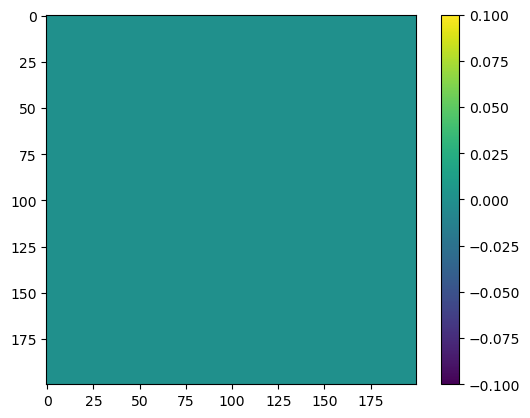

In [99]:
plt.imshow(aaa.as_array()[72,:,:])
plt.colorbar()

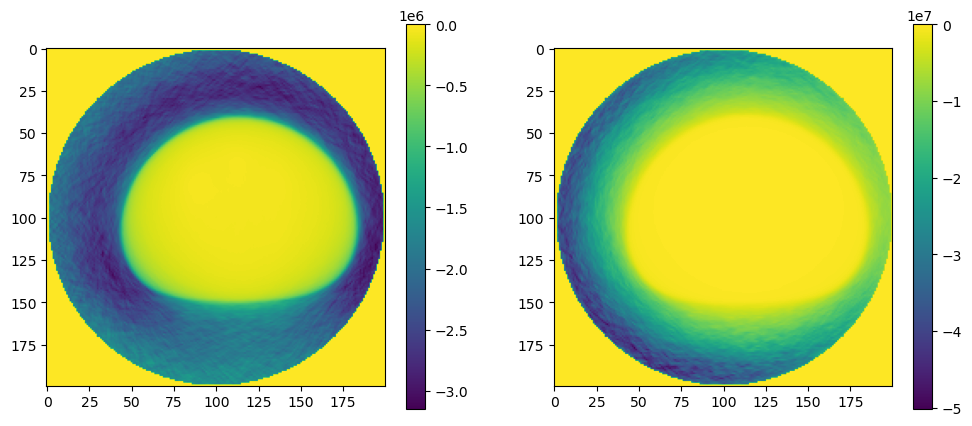

In [93]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(hM.as_array()[72,:,:])
plt.colorbar()
plt.subplot(122)
plt.imshow(-aaa.as_array()[72,:,:])
plt.colorbar()

In [80]:
b.shape

(100,)

/tmp/ipykernel_1015/3817116795.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow((-hM.as_array()/aaa.as_array())[2,:,:])


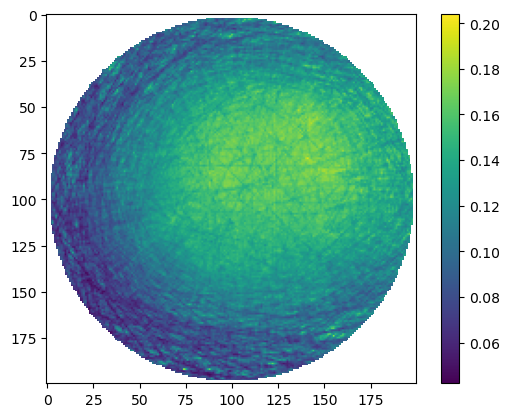

In [77]:
plt.imshow((-hM.as_array()/aaa.as_array())[2,:,:])
plt.colorbar()

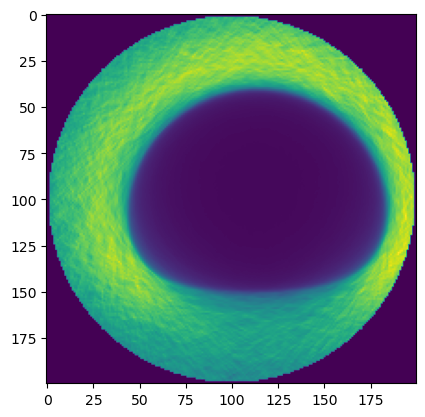

In [41]:
plt.imshow(kappa.as_array()[55,:,:]**2)

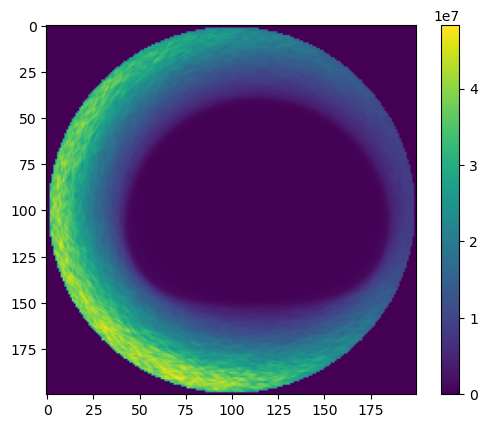

In [41]:
plt.imshow(aaa.as_array()[60,:,:])
plt.colorbar()

In [25]:
import time
ts = time.time()
newG = ll.gradient(image)
print(time.time()-ts)

2.919595241546631


In [26]:
ts=time.time()
newFP = acq_model.forward(image)
bp = acq_model.backward(template/newFP-1)
print(time.time()-ts)

3.962815761566162


# My Preconditioner

(BP (1/\bar{y} (FP(1)))

Open issue: do we really need FP(1)? It takes an extra forward projection! (\bar{y} at least gets reused)

1. Save my diagonal preconditioner in SIRF format (to be used when doing diagonal preconditioning)
2. Save its square root in np format (to be used when doing diagonal + filter)

In [97]:


ybar = acq_model.forward(image)
#fp1 = ss_model.forward(image.get_uniform_copy(1))

myKStir = acq_model.backward(multCorr/ybar)
myKarr = myKStir.as_array()
#myKsqroot = np.sqrt(myK.as_array()+1e-10)

myKarr += rdp_hess_diag (image.as_array(),newKarr,penEps,0.0008,image.voxel_sizes())

In [98]:
myKarr.shape

(127, 200, 200)

In [99]:
mask = myKStir.as_array()>1e-10

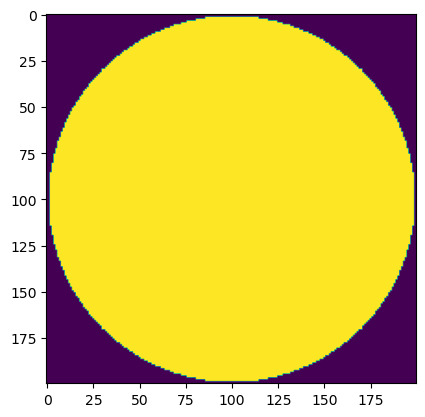

In [100]:
plt.imshow(mask[64,:,:])

In [490]:
structuring_element = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]]).astype(bool)
structuring_element = structuring_element.reshape((1,3,3))  
precDil = myKarr  
inMask = ndi.binary_erosion(mask,structure=structuring_element)
for _ in range(22):
    precDil = ndi.grey_dilation(precDil,structure=structuring_element)
    precDil[inMask] = myKarr[inMask]


precDil += 1e-5
precDil = ndi.gaussian_filter(precDil,2)
myK = np.sqrt(1/precDil)

In [188]:
myPrec = image.get_uniform_copy(0)
myPrec.fill(1/precDil)

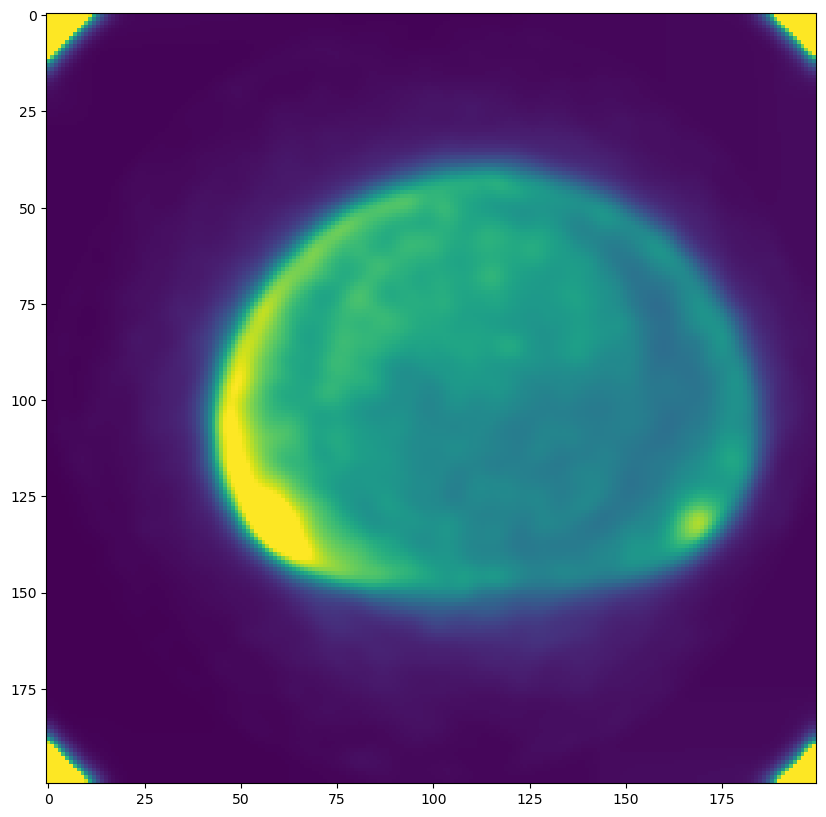

In [496]:
plt.figure(figsize=(10,10))
plt.imshow(myK[11,:,:],vmax=0.0009)
#plt.imshow(ndi.gaussian_filter(precDil[95,:,:],1))
#plt.yscale('log')

In [21]:
def priorHessTimesOne (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                #    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += 2*tempW*(eps_+2*shiftImm_)**2 / (inpImm_+shiftImm_+2*np.abs(inpImm_-shiftImm_)+eps_)**3
                
    return rdpG_

In [47]:
#myHess = priorHessTimesOne(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
myHessMyK = priorHessTimesOne(image.as_array(),myKsqroot,penEps,image.voxel_sizes())
myHessKappa = priorHessTimesOne(ndi.gaussian_filter(image.as_array(),1),kappa.as_array(),penEps,image.voxel_sizes())
myKsqroot = np.sqrt(myKsqroot**2 + 1/700*myHessKappa)
#myHessDiag = priorHessDiag(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())

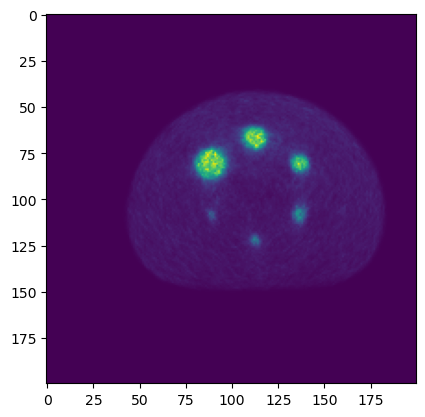

In [23]:
plt.imshow(inpImage[72,:,:])

In [1]:
plt.imshow(myHessKappa[3,:,:]) #/700,vmax=3e8)

NameError: name 'plt' is not defined

In [85]:
structuring_element = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]]).astype(bool)
structuring_element = structuring_element.reshape((1,3,3))                 
myKsqroot_a = myKsqroot.copy()     
mT = (myKsqroot>1)
for itI in range(22):
    print(itI)
    myKsqroot = ndi.grey_dilation(myKsqroot,structure=structuring_element)
    myKsqroot[mT] = myKsqroot_a[mT]
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


## Compute masks

1. Do not update outside the innermost ring.
2. If filtering, smooth the border to avoid ringing

In [52]:
mask = kappa.as_array()<1
print(mask.dtype)
#mask = (ndi.binary_erosion(mask))
mask[0,:,:]=mask[1,:,:]
mask[-1,:,:]=mask[-2,:,:]
mask = ndi.binary_dilation(mask,iterations=2)

# print(mask.dtype)
mask = 1 - mask
# print(mask.dtype)
maskSmooth = ndi.gaussian_filter(mask.astype(np.float32),(0,1.5,1.5))

maskS = image.get_uniform_copy(0)

maskS.fill(maskSmooth)

bool


In [24]:
mask.dtype

dtype('int64')

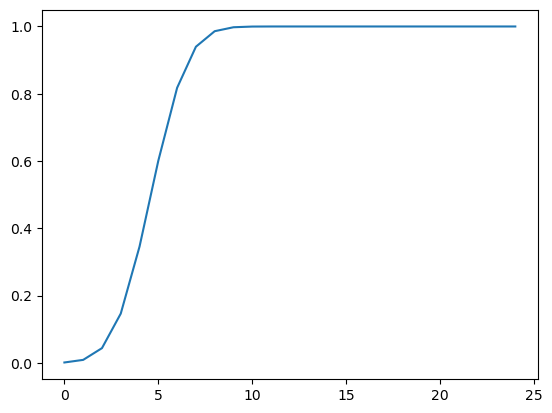

In [29]:
plt.plot(maskSmooth[72,100,:25])

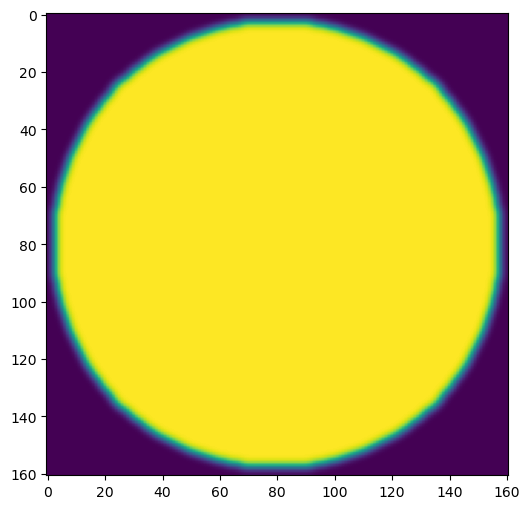

In [30]:
plt.figure(figsize=(6,6))
plt.imshow(maskSmooth[-1,:,:])

In [248]:
mask = mask.astype(bool)

### Define the filter

This is a 2D interpolation of the ram-lak filter, convolved with the shepp-logan window.
It also includes the possibility to account for TOF if present.

In [524]:
def makeFFT_2D_filter (imShape_,tRes_=600,pixS_=2):
    d_ = .8
    order = 2*np.power(2,np.ceil(np.log2(imShape_[1]))).astype(np.uint32)
   # freqN = np.power(2,np.ceil(np.log2(imShape_[1]//2))).astype(np.uint32)
    print (order)
    freqN = order//2
    nFreq = np.arange(0,freqN +1)
    filtImpResp = np.zeros((len(nFreq),))
    filtImpResp[0]=1/4
    filtImpResp[1::2]=-1/((np.pi*nFreq[1::2])**2)

    #TOF part
    if (tRes_ > 0):
        xV_ = nFreq*pixS_
        tRes_ = tRes_*0.15/2.35 # 300 mm /ns --> .3 mm/ps --> /2 because 2 photons 
        tKern_ = np.exp(-(xV_**2/(4*tRes_**2)))
        filtImpResp *=tKern_

    # Once the filter has been defined in image space, convert it to Fourier space
    filtImpResp = np.concatenate([filtImpResp,filtImpResp[-2:0:-1]])
    ftFilt = 2 * np.real(np.fft.fft(filtImpResp)) # check! when implemented correctly the imag part is zero within numerical precision
    ftFilt = ftFilt[:(freqN+1)]
    
    # Apply the shepp-logan window
    fV = 2*np.pi*(np.arange(1,freqN+1))/imShape_[1]
    ftFilt[1:] *= (np.sin(fV/(2*d_)) / (fV/(2*d_)))
    ftFilt[ftFilt<0]=0

    # interpolate to 2D
    xf = np.arange(0,imShape_[1]//2+1).reshape((1,imShape_[1]//2+1))
    yf = xf.transpose()
    freqR = np.sqrt(xf**2+yf**2)
    interpF = np.interp(freqR,nFreq,ftFilt,right=0)
    if (imShape_[1]%2):
            interpF = np.concatenate([interpF,interpF[-1:0:-1,:]],axis=0)
            interpF = np.concatenate([interpF,interpF[:,-1:0:-1]],axis=1)
            interpF = interpF.reshape((1,)+imShape_[1:])            
    else:
            interpF = np.concatenate([interpF,interpF[-2:0:-1,:]],axis=0)
            interpF = np.concatenate([interpF,interpF[:,-2:0:-1]],axis=1)
            interpF = interpF.reshape((1,)+imShape_[1:])
 #   interpF = interpF.reshape((1,)+imShape_[1:])
    return interpF
    


In [525]:
myFilt = makeFFT_2D_filter(inpImage.shape) # Add TOF res and pixel size if problem is TOF

512


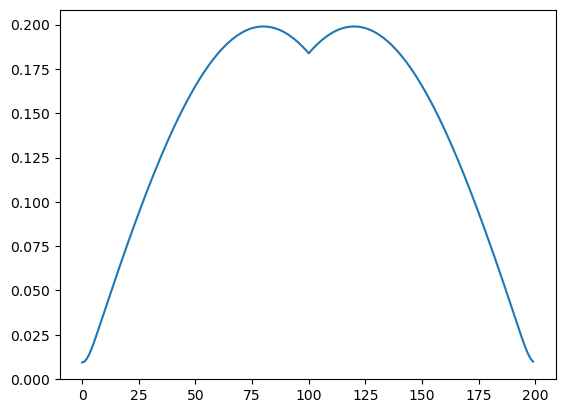

In [526]:
plt.plot(myFilt[0,0,:])

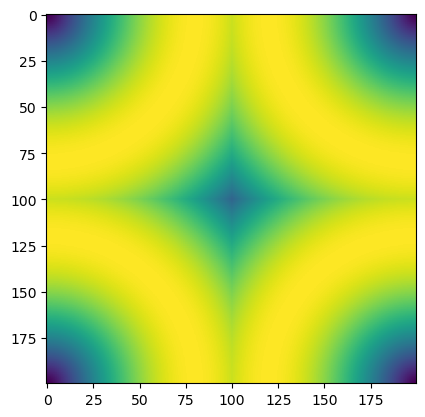

In [527]:
plt.imshow(myFilt[0,:,:])

# Recon loop

Recon with preconditioned, maybe conjugate gradient descent

In [256]:
# # UNCOMMENT and run to "restart" from the clean image

# image.fill(inpImage)
# acq_model.forward(image,out=fwdProj)

## Version 1: Strictly positive, (conjugate) diagonal precondition

It's conjugate if conjugateFlag is True

Generally always works much better. With long numbers of iterations it should be useful to "reset" from time to time. But we're aiming at using like 2 or 3 iterations so not an issue

betaPen =1/700 and penEps = 1e-3 * max are given by organizers

In [273]:
nIt = 30
conjugateFlag = True

recItV_V1 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V1[0,:,:,:] = image.as_array()
betaPen =  0.0008
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

for itIdx in range(nIt):
    # Backproject tomographic error term
    gradSino = template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) 
    # Compute gradient of penalty
    pGrad = stir_prior.gradient(image)
    grad = gradI - pGrad
    
    # Search direction is gradient divived by preconditioner
    sDir = grad*myPrec  #*maskS / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1 so 1e-10 always trivial

    # Uncomment to conver to conjugate 
    # Conjugate gradient part
    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   


    # Tomographic step size    
    # Computing the numerator of the step size of the tomographic part,
    # potentially only on a subset of the data (or even more quickly
    ss_model.forward(sDir,out=fPsDir) #,subset_num=0,num_subsets=42) #*multCorr
   #  ssNum = sDir.dot(gradI)
   #  ssDen = fPsDir.dot((fPsDir/fwdProj)) #*42
   #  ssTomo = ssNum/ssDen

   #  # penalty step size
   # #penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
   #  # Full step size
   #  ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
   #  print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))

    ssNum = sDir.dot(grad)
    ssDen = fPsDir.dot((fPsDir/fwdProj)) #.maximum(addCorr*capFact)))
    rdpDen = rdp_den_exact (image.as_array(),sDir.as_array(),newKarr,penEps,image.voxel_sizes(),betaPen,alpha_=0)
    ss = ssNum/( ssDen+rdpDen)    
    print (f'num= {ssNum:.2e} denT= {ssDen:.2e} denRDP= {rdpDen:.2e}')
    image += ss*sDir    

    # Cut negative values
    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    image.fill(imArr)

    # Update current estimate of sinogram
    acq_model.forward(image,out=fwdProj)

    recItV_V1[itIdx+1,:,:,:] = image.as_array()
    

num= 2.80e+05 denT= 6.21e+03 denRDP= 2.00e+05
num= 5.68e+04 denT= 3.14e+03 denRDP= 6.36e+04
num= 2.19e+04 denT= 1.72e+03 denRDP= 2.28e+04
num= 1.16e+04 denT= 1.39e+03 denRDP= 1.07e+04
num= 8.54e+03 denT= 1.30e+03 denRDP= 7.51e+03
num= 6.96e+03 denT= 1.08e+03 denRDP= 6.58e+03
num= 6.38e+03 denT= 9.93e+02 denRDP= 6.55e+03
num= 6.05e+03 denT= 9.53e+02 denRDP= 6.34e+03
num= 5.95e+03 denT= 9.49e+02 denRDP= 6.54e+03
num= 5.87e+03 denT= 9.48e+02 denRDP= 6.47e+03
num= 5.75e+03 denT= 9.30e+02 denRDP= 6.48e+03
num= 5.73e+03 denT= 9.31e+02 denRDP= 6.47e+03
num= 5.69e+03 denT= 9.29e+02 denRDP= 6.53e+03
num= 5.67e+03 denT= 9.29e+02 denRDP= 6.46e+03
num= 5.64e+03 denT= 9.28e+02 denRDP= 6.54e+03
num= 5.63e+03 denT= 9.30e+02 denRDP= 6.49e+03
num= 5.60e+03 denT= 9.25e+02 denRDP= 6.52e+03
num= 5.61e+03 denT= 9.30e+02 denRDP= 6.50e+03
num= 5.59e+03 denT= 9.30e+02 denRDP= 6.56e+03
num= 5.59e+03 denT= 9.32e+02 denRDP= 6.51e+03
num= 5.56e+03 denT= 9.28e+02 denRDP= 6.55e+03
num= 5.57e+03 denT= 9.31e+02 denRD

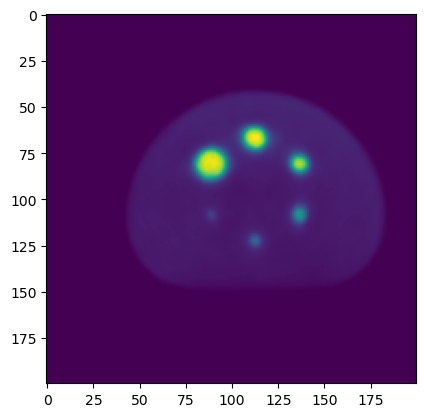

In [277]:
plt.imshow(recItV_V1[-1,72,:,:])

## Version 2: Strictly positive, diagonal + filter preconditioner

Here what we're doing is Fessler suggestion of sqrt(diagPrec) * ramp-like filtering * sqrt(diagPrec)
Notice that we can't filter in STIR (it seems) so we need to copy in an array, filter, re-put in stir. (lots of overhead in time)

Rest is as before

It's conjugate if conjugateFlag is True

Generally always works much better. With long numbers of iterations it should be useful to "reset" from time to time. But we're aiming at using like 2 or 3 iterations so not an issue

betaPen =1/700 and penEps = 1e-3 * max are given by organizers

In [528]:
image.fill(inpImage)
fwdProj = acq_model.forward(image)

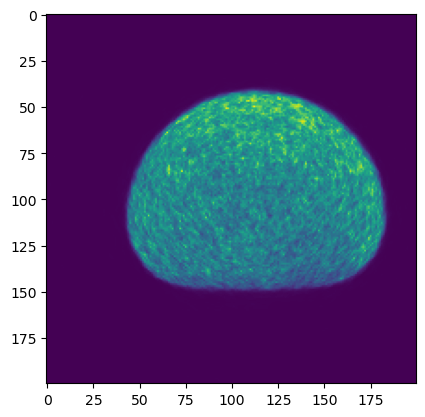

In [281]:
plt.imshow(inpImage[60,:,:])

In [255]:
iRef = STIR.ImageData('./output/geWeight_Neg_Diag_ConjQuad/mMR_NEMA/iter_0037.hv')

In [529]:
nIt = 20
conjugateFlag = True

recItV_V4 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V4[0,:,:,:] = image.as_array()
betaPen =  0.0008
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)
grad = image.get_uniform_copy(0)

for itIdx in range(nIt):
    capFact = 2.5/(5+(itIdx/10)**2)
    gradSino = (template-fwdProj)/fwdProj.maximum(addCorr*capFact)
 #   print('computed grad')
    acq_model.backward(gradSino,out=gradI) #*multCorr)
#    print('BP')
    pGrad = betaPen*rdp_grad(image.as_array(),newKarr,penEps,image.voxel_sizes()) #stir_prior.gradient(image)
    gradArr = gradI.as_array()
    gradArr -=pGrad
 #   print('done rdp G')
    grad.fill(gradArr)
#    print('filled grad')

    # Filter partGradArr
#    gradArr = grad.as_array()
    # apply square root of diagonal prec
    gradArr *= (myK)
#    gradArr *= maskSmooth
    # Convert in fourier and apply the 2D filter in the axial planes
    gradArr = ndi.gaussian_filter(gradArr,(0.6,0,0))    
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    # smooth lightly over the z direction
 
    # apply diagonal preconditioner
    gradArr *= myK
#    gradArr *= maskSmooth
    # put the results in the STIR array
    sDir.fill(gradArr*mask)

    # Uncomment to conver to conjugate 
    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   

    # # Tomographic step size
    ss_model.forward(sDir,out=fPsDir) 
    ssNum = sDir.dot(grad)
    ssDen = fPsDir.dot((fPsDir/fwdProj.maximum(addCorr*capFact)))
    rdpDen = rdp_den_exact (image.as_array(),sDir.as_array(),newKarr,penEps,image.voxel_sizes(),betaPen,alpha_=0)
    ss = ssNum/( ssDen+rdpDen)
    image += ss*sDir
    print (f'num= {ssNum:.2e} denT= {ssDen:.2e} denRDP= {rdpDen:.2e}')
    # ssNum = sDir.dot(gradI)
    # penSSNum = sDir.dot(pGrad)
    # ssDen = fPsDir.dot((fPsDir/fwdProj))
    # ssTomo = ssNum/ssDen
    # # penalty step size
    # rdp_den_exact (image.as_array(),sDir.as_array(),kappa.as_array(),penEps,1/700,image.voxel_sizes(),alpha_=0)
    #penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    # ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    # print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))

    # # update image and sinogram
    # image += ss*sDir

    # # Cut negatives
    # imArr = image.as_array()
    # imArr[imArr<0]=0
    # imArr[np.isnan(imArr)] = 0
    # image.fill(imArr)
    # # forward project current estimate
    # acq_model.forward(image,out=fwdProj)
    fwdProj += ss*fPsDir
    recItV_V4[itIdx+1,:,:,:] = image.as_array()
    
    

continuing
num= 2.35e+04 denT= 1.39e+01 denRDP= 2.12e+03
continuing
num= 8.16e+03 denT= 6.37e+00 denRDP= 7.82e+02
continuing
num= 3.22e+03 denT= 3.15e+00 denRDP= 3.09e+02
continuing
num= 1.78e+03 denT= 2.58e+00 denRDP= 1.60e+02
continuing
num= 1.21e+03 denT= 2.66e+00 denRDP= 1.02e+02
continuing
num= 8.78e+02 denT= 2.89e+00 denRDP= 7.50e+01
continuing
num= 6.41e+02 denT= 2.71e+00 denRDP= 5.39e+01
continuing
num= 5.30e+02 denT= 2.82e+00 denRDP= 4.38e+01
continuing
num= 4.58e+02 denT= 2.97e+00 denRDP= 3.86e+01
continuing
num= 3.93e+02 denT= 2.93e+00 denRDP= 3.39e+01
continuing
num= 3.35e+02 denT= 2.65e+00 denRDP= 2.95e+01
continuing
num= 2.88e+02 denT= 2.32e+00 denRDP= 2.60e+01
continuing
num= 2.44e+02 denT= 1.92e+00 denRDP= 2.26e+01
continuing
num= 2.05e+02 denT= 1.55e+00 denRDP= 1.95e+01
continuing
num= 1.72e+02 denT= 1.24e+00 denRDP= 1.67e+01
continuing
num= 1.44e+02 denT= 9.90e-01 denRDP= 1.42e+01
continuing
num= 1.22e+02 denT= 8.01e-01 denRDP= 1.21e+01
continuing
num= 1.05e+02 denT= 

In [64]:
precCode = STIR.ImageData('output/geWeight_Filt_newTest_uS/mMR_NEMA/myPrec.hv')

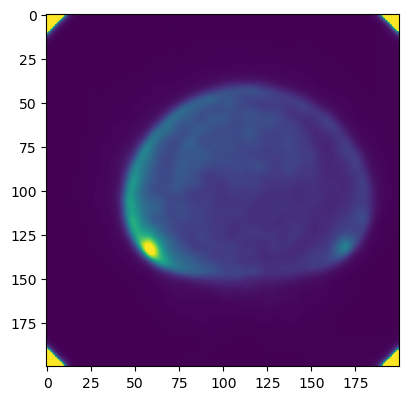

In [530]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow((myK**2)[11,:,:],vmax=.0000015) #,vmin=.99,vmax=1.01) #,vmin=0,vmax=.0005)
#plt.colorbar()
# plt.subplot(122)
# plt.imshow(precCode.as_array()[60,:,:],vmin=0,vmax=.0005)

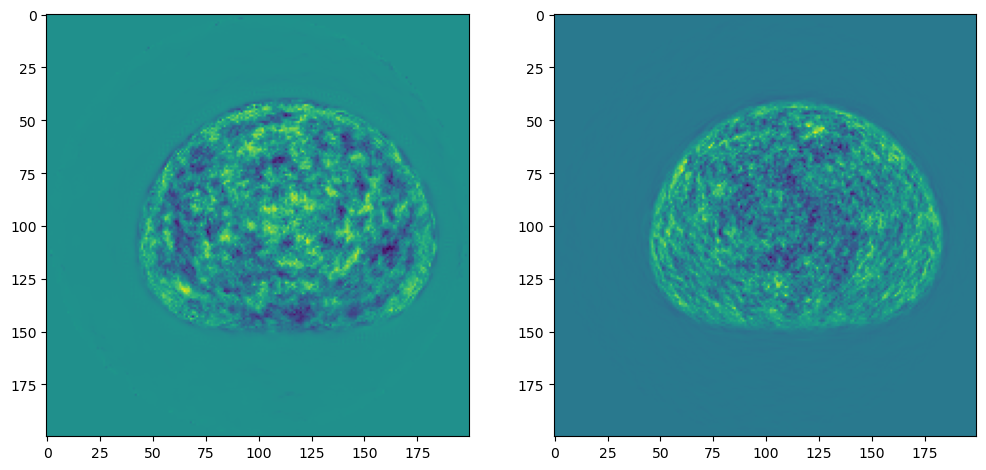

In [547]:
plt.figure(figsize=(12,10))
plt.subplot(121)
#plt.imshow((gradI.as_array()*myK**2)[42,:,:]) #,vmin=-3e-4,vmax=3e-4)
#plt.imshow((pGrad*myK**2)[:,:,120],vmax=.0005,vmin=-.0005) #,vmin=-3e-4,vmax=3e-4)
plt.imshow((sDir.as_array())[19,:,:],vmin=-2e-5,vmax=2e-5)
#plt.colorbar()
plt.subplot(122)
#plt.imshow((image.as_array()[:,:,100]),vmax=0.003,cmap='gray')
#plt.contour((pGrad*myK**2)[:,:,100],[-0.0002,0.0002]) #,vmin=-3e-4,vmax=3e-4)
plt.imshow((pGrad*myK**2)[19,:,:])
#plt.colorbar()

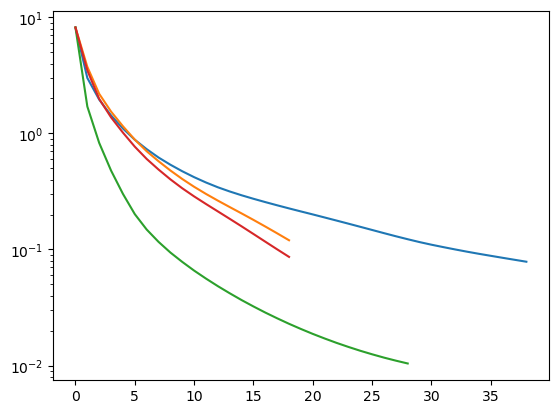

In [532]:
rI = iRef.as_array()#recItV_V2[-1,:,:,:]
dV = (recItV_V3 - np.expand_dims(rI,axis=0))**2
dV2 = (recItV_V2 - np.expand_dims(rI,axis=0))**2
dV3 = (recItV_V1 - np.expand_dims(rI,axis=0))**2
dV4 = (recItV_V4 - np.expand_dims(rI,axis=0))**2
plt.plot(np.sum(np.sum(np.sum(dV,axis=-1),axis=-1),axis=-1)[:-2])
plt.plot(np.sum(np.sum(np.sum(dV2,axis=-1),axis=-1),axis=-1)[:-2])
plt.plot(np.sum(np.sum(np.sum(dV3,axis=-1),axis=-1),axis=-1)[:-2])
plt.plot(np.sum(np.sum(np.sum(dV4,axis=-1),axis=-1),axis=-1)[:-2])
plt.yscale('log')

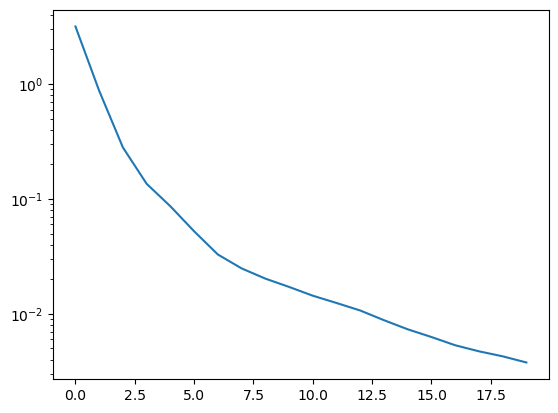

In [508]:
plt.plot(np.sum(np.sum(np.sum(np.diff(recItV_V2,axis=0)**2,axis=-1),axis=-1),axis=-1))
plt.yscale('log')

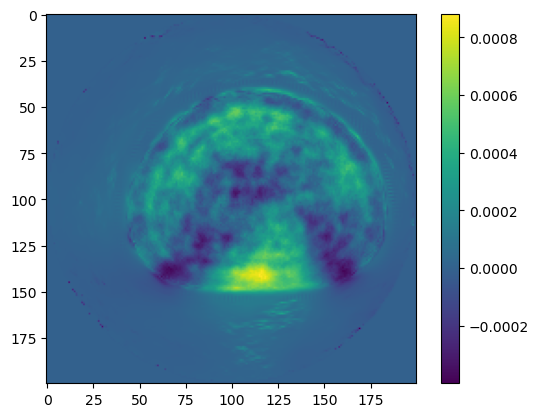

In [510]:
# plt.subplot(121)
#plt.imshow(recItV_V3[-1,72,:,:],vmin=0)
# plt.subplot(122)
plt.imshow((recItV_V2[-1,:,:,:]-iRef.as_array())[40,:,:])
plt.colorbar()

In [290]:
ssDen, rdpDen

(0.28164455, 174.629840234375)

In [315]:
i2 = STIR.ImageData('./output/geWeight_NegThrSinoCap_Filt_ConjQuad/mMR_NEMA/iter_0023.hv')


In [170]:
denI = fPsDir*fPsDir/

(11, 127, 200, 200)

In [409]:
i1 = image.as_array()
i1[i1<0].size

1049723

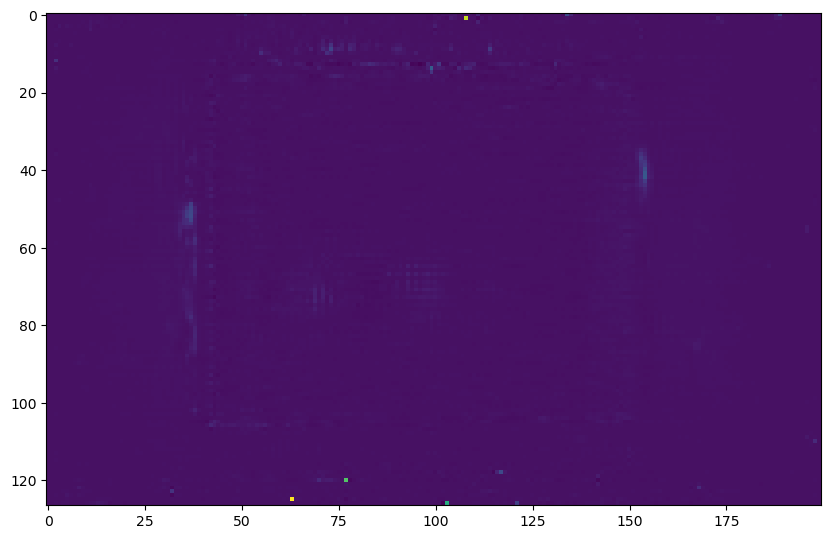

In [514]:
plt.figure(figsize=(10,10))
plt.imshow((sDir.as_array()*grad.as_array())[:,:,100])
#plt.contour(i1[:,:,100],[0],colors='r')

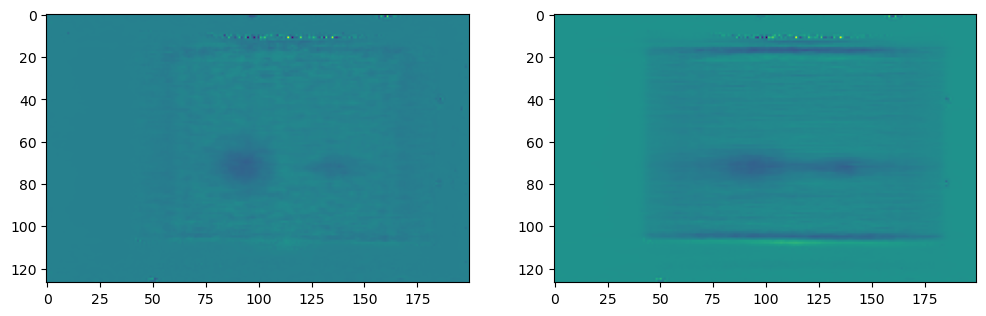

In [407]:
plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(sDir.as_array()[:,100,:])
plt.subplot(122)
plt.imshow((grad.as_array()*myK**2)[:,100,:])

In [183]:
fPsDir.dot((fPsDir/fwdProj))

30.841469

In [106]:
ssNum = sDir.dot(grad)
ssNum

42848.605

In [220]:
ssDen = fPsDir.dot((fPsDir/fwdProj))
ssDen, rdpDen # ssNum/ssDen

(57.943287, 2210.5092875)

In [400]:
rdpDen,wI = rdp_den_exact (image.as_array(),sDir.as_array(),newKarr,penEps,image.voxel_sizes(),betaPen,alpha_=0)
ssNum/(ssDen+rdpDen)
#inpImm_,sDir_,kappa_,eps_,pixS_,beta_=1/700,alpha_=0)

4.0301550995619415

In [234]:
wI.sum()

51833.664

In [423]:
i0 = i1 - 3.598 * sDir.as_array()

In [426]:
help (range)

Help on class range in module builtins:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      True if self else False
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash

In [429]:
rdpL = []
for idx,sV in enumerate(np.arange(0,5,.1)):
    print(sV)
    rdpL.append(betaPen*rdp_value(i0+sV*sDir.as_array(),newKarr,penEps,image.voxel_sizes()))
    

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9


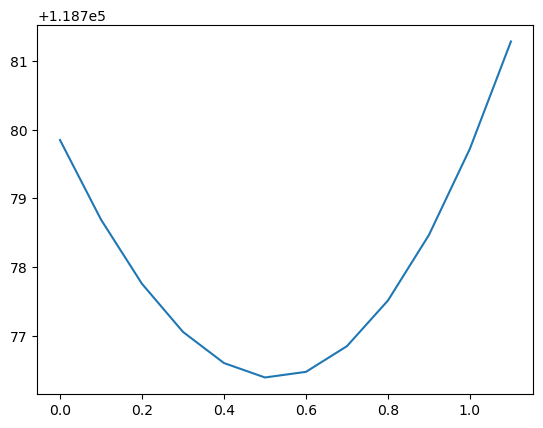

In [437]:
plt.plot(np.arange(0,5,.1)[:12],rdpL[:12])

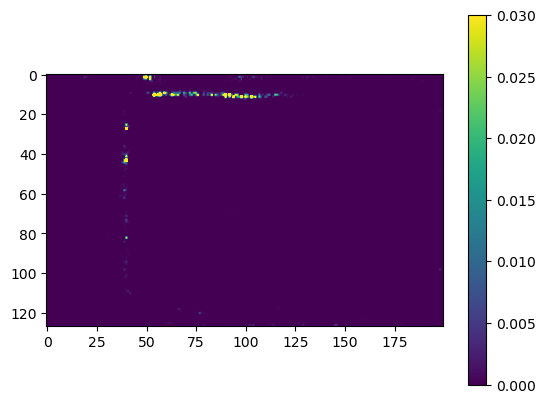

In [405]:
plt.imshow(wI[:,:,100],vmax=.03,vmin=0)
plt.colorbar()

In [10]:
tImmArrSm = ndi.gaussian_filter(inpImage,0.8)
image.fill(tImmArrSm)

ybar = acq_model.forward(image)

NameError: name 'acq_model' is not defined

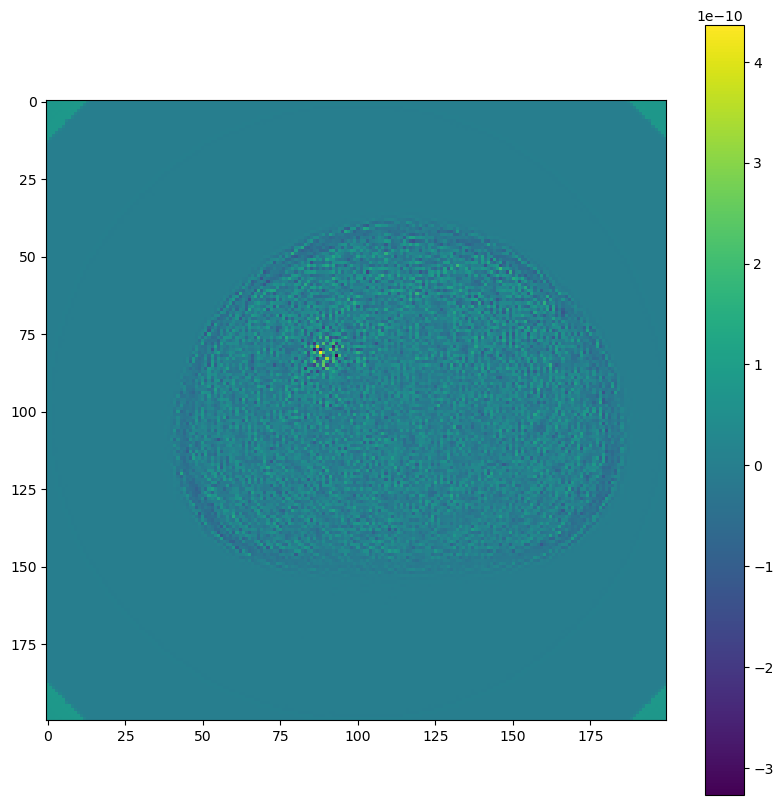

In [130]:
plt.figure(figsize=(10,10))
slIdx=60
#plt.imshow(inpImage[slIdx,:,:])
#plt.imshow(inpImage[slIdx,:,:]+gradArr[slIdx,:,:]*6.7)
plt.imshow(gradArr[slIdx,:,:]*4.3e-7)
plt.colorbar()

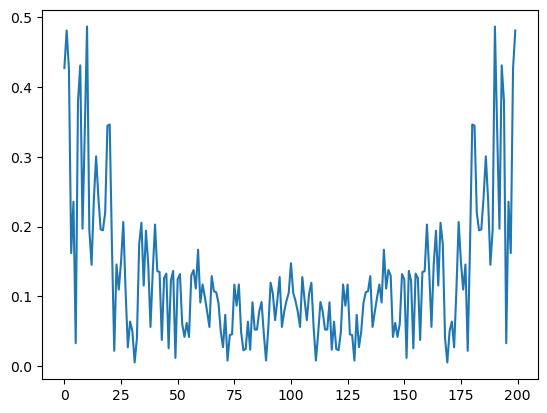

In [174]:
plt.plot(np.abs(np.fft.fft2((pGrad.as_array()/(myKsqroot**2))[72,:,:]))[:,0])

In [116]:
invFilt[0,0,0]

1.0

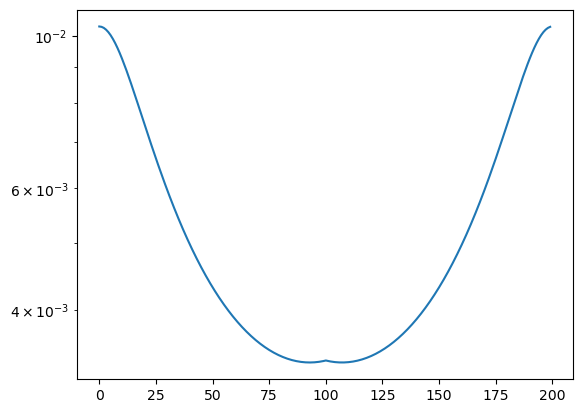

In [161]:
plt.plot(invFilt[0,20,:])
plt.yscale('log')

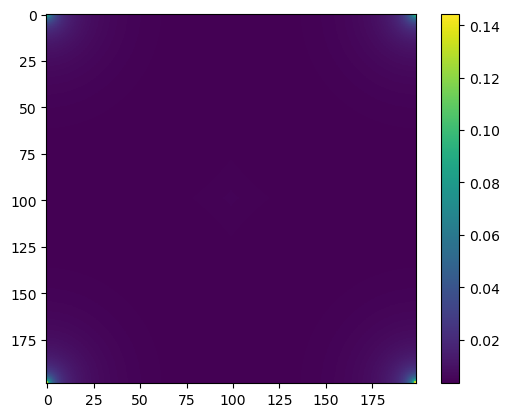

In [158]:
plt.imshow((invFilt[0,1:,1:]))# ,vmax=.5)
plt.colorbar()

In [157]:
invFilt = 1/(myFilt+1e-20)
invFilt[myFilt<0.0001]=0
invFilt/= invFilt[0,0,0]
#invFilt[0,0,0]=1

In [182]:
gradB = (gradArr*mask)*(np.sqrt(myK.as_array())) #myKsqroot
gradB = np.fft.fft2(gradB,axes=(1,2))
gradB *= (invFilt)
gradB = np.real(np.fft.ifft2(gradB,axes=(1,2)))
gradB *= (np.sqrt(myK.as_array()))
np.dot(gradB.flat,(gradArr*mask).flat)

24.64987347307711

In [181]:
#ts = time.time()
gradI.norm()
#print(time.time()-ts)

869328.8125

In [ ]:
plt.imshow(

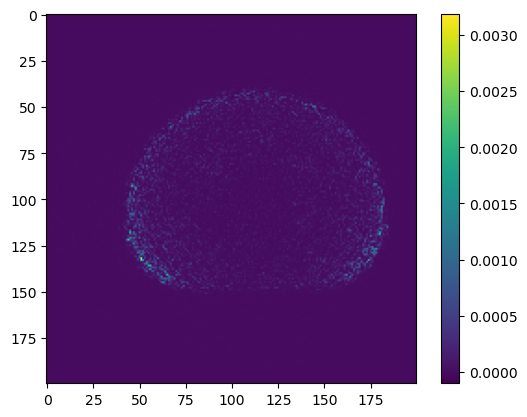

In [130]:
plt.imshow((gradB*gradArr)[76,:,:])#,vmax=1e1)
plt.colorbar()

In [90]:
rdp_den_exact (image.as_array(),sDir.as_array(),kappa.as_array(),penEps,1/700,image.voxel_sizes(),alpha_=0)

786.8497642299108

/tmp/ipykernel_2463/2863541044.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow((grad.as_array()/(1/700*myHessKappa))[72,:,:]) #,vmin=-1e-5)


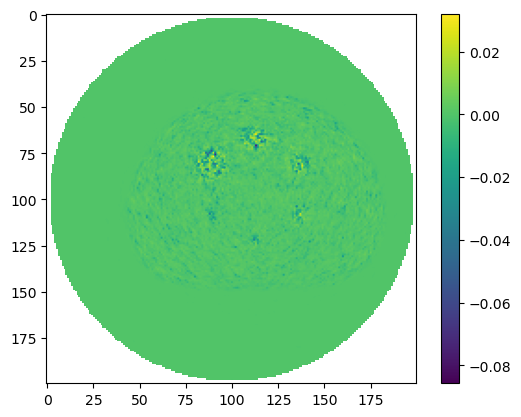

In [128]:
plt.imshow((grad.as_array()/(1/700*myHessKappa))[72,:,:]) #,vmin=-1e-5)
plt.colorbar()

In [92]:
grad2 = grad.as_array()
    # apply square root of diagonal prec
grad2 /= (myKsqroot)
#    gradArr *= maskSmooth
    # Convert in fourier and apply the 2D filter in the axial planes
grad2 = np.fft.fft2(grad2,axes=(1,2))
grad2 *= myFilt
grad2 = np.real(np.fft.ifft2(grad2,axes=(1,2)))

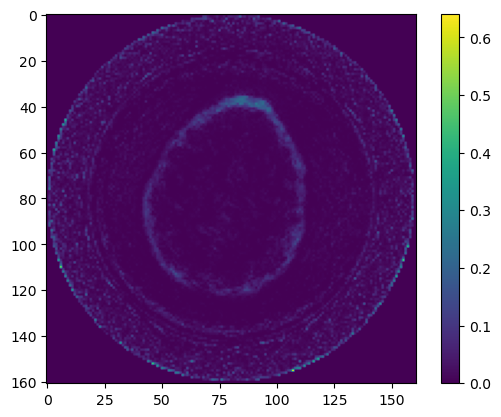

In [107]:
plt.imshow(np.abs(grad2*grad.as_array()/myKsqroot)[40,:,:])
plt.colorbar()

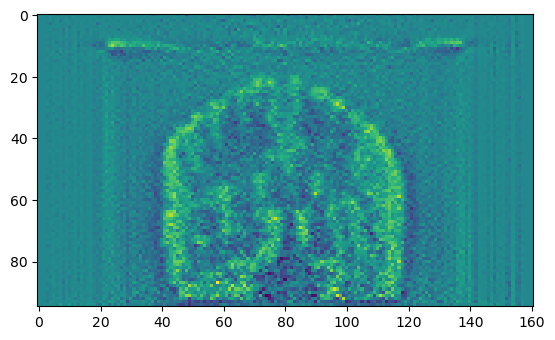

In [103]:
plt.imshow((grad2*mask/myKsqroot)[:,75,:])

In [43]:
ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
ss

7.497116643149739

In [44]:
print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))


it: 0, num: -3.8e+03 den: 6.2e+01 penNum 3.3e+05 penDen 4.3e+04


In [45]:
33/4.3

7.674418604651163

In [27]:
image.sapyb(1,sDir,11).min()

-0.0009065671

In [46]:
linV0 = np.linspace(0,20,50)
pVal = np.zeros_like(linV0)
for idx,i in enumerate(linV0):
    pVal[idx] = stir_prior(image.sapyb(1,sDir,i).maximum(0))

In [94]:
(image.voxel_sizes())

(1.6565, 1.6565, 1.6565)

In [47]:
linV2 = np.linspace(0,20,50)
pValn = np.zeros_like(linV2)
pVal2 = np.zeros_like(linV2)
for idx,i in enumerate(linV2):
    i2 = image.sapyb(1,sDir,i)
    pValn[idx] = stir_prior(i2)
    pVal2[idx] = rdp_value (i2.as_array(),kappa.as_array(),penEps,image.voxel_sizes())

In [31]:
pVal3 = np.zeros_like(linV2)
for idx,i in enumerate(linV2):
    i2 = image.sapyb(1,sDir,i).maximum(0)
    pVal3[idx] = rdp_value (i2.as_array(),kappa.as_array(),penEps,image.voxel_sizes())    

(950000.0, 1200000.0)

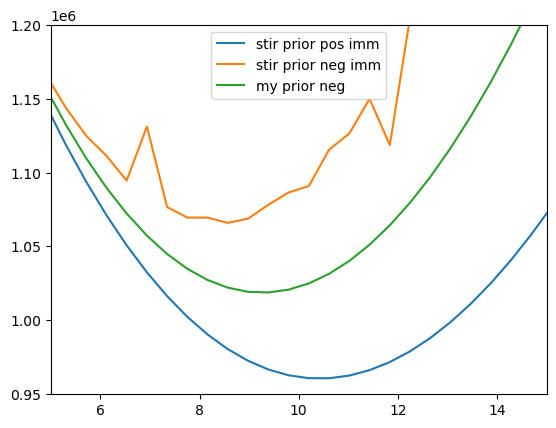

In [53]:
plt.plot(linV0,.998*pVal,'-')
plt.plot(linV2,pValn,'-')
plt.plot(linV2,1.0011/700*pVal2,'-')
#plt.plot(linV2,1.0/700*pVal3,'-')
plt.legend(['stir prior pos imm','stir prior neg imm','my prior neg']) #,'my prior pos'])
plt.xlim(5,15)
plt.ylim(9.5e5,1.2e6)

In [60]:
print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,betaPen*penSSNum,betaPen*penSSDen))


it: 0, num: 7.9e+03 den: 1.8e+01 penNum 1.1e+03 penDen 6.5e+01


In [58]:
theirH = stir_prior.accumulate_Hessian_times_input(image,image.get_uniform_copy(1))

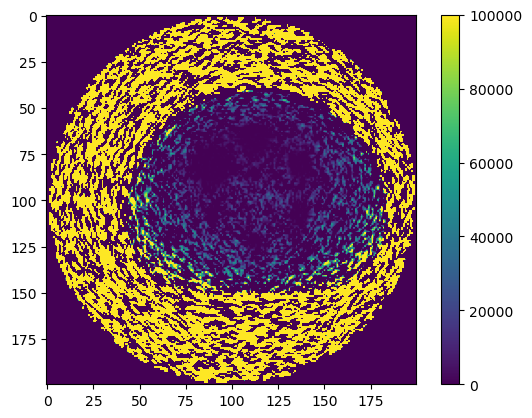

In [74]:
plt.imshow(theirH.as_array()[72,:,:],vmin=0,vmax=1e5)
plt.colorbar()

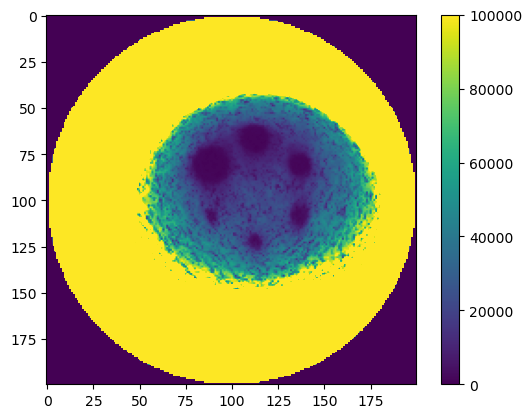

In [75]:
plt.imshow(myHessKappa[72,:,:]/7000,vmax=1e5)
plt.colorbar()

## Version 3: allow negative values and just truncate the sinogram

For reasons it doesn't help with convergence speed! Anyway... Leave it there for now.
If one wants to introduce filter just copy from up there.

**Note how this way we are able to recycle forward projections!!**

In [266]:
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)

In [267]:
nIt = 30
conjugateFlag = True

recItV_V3 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V3[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

# Non-negative denominator!
sinDenoStir = fwdProj.clone()

for itIdx in range(nIt):
    gradSino =  (template-fwdProj)/sinDenoStir
    acq_model.backward(gradSino,out=gradI) #*multCorr)

    # Need to use my re-implementation that handles negative denominators.
    pGradA = betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    pGrad.fill(pGradA)
    grad = gradI - pGrad
    sDir = grad*maskS / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1

    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   

    ss_model.forward(sDir,out=fPsDir,subset_num=0)

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/sinDenoStir))
    ssTomo = ssNum/ssDen
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))

    # update image and sinogram
    image += ss*sDir
    fwdProj += ss*fPsDir

    recItV_V3[itIdx+1,:,:,:] = image.as_array()
    
    

continuing
it: 0, num: 1.4e+04 den: 6.9e+04 penNum 2.6e+06 penDen 8.1e+07
continuing
it: 1, num: -2.3e+03 den: 6.5e+04 penNum 1.7e+06 penDen 2.4e+07
continuing
it: 2, num: 4.0e+03 den: 2.0e+05 penNum 3.4e+06 penDen 7.3e+07
continuing
it: 3, num: -3.2e+04 den: 2.4e+05 penNum 3.3e+06 penDen 5.8e+07
continuing
it: 4, num: -5.1e+04 den: 4.2e+05 penNum 3.6e+06 penDen 6.5e+07
continuing
it: 5, num: -7.2e+04 den: 3.8e+05 penNum 2.9e+06 penDen 5.2e+07
continuing
it: 6, num: -8.7e+04 den: 3.3e+05 penNum 2.3e+06 penDen 3.6e+07
continuing
it: 7, num: -1.0e+05 den: 3.3e+05 penNum 2.0e+06 penDen 3.0e+07
continuing
it: 8, num: -1.2e+05 den: 3.4e+05 penNum 1.9e+06 penDen 2.7e+07
continuing
it: 9, num: -1.4e+05 den: 3.3e+05 penNum 1.7e+06 penDen 2.5e+07
continuing
it: 10, num: -1.5e+05 den: 3.3e+05 penNum 1.6e+06 penDen 2.3e+07
continuing
it: 11, num: -1.7e+05 den: 3.5e+05 penNum 1.6e+06 penDen 2.3e+07
continuing
it: 12, num: -1.9e+05 den: 3.5e+05 penNum 1.5e+06 penDen 2.3e+07
continuing
it: 13, num: 

## Version 4: allow negative values AND filter

In [272]:
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)

In [273]:
nIt = 30
conjugateFlag = True

recItV_V4 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V4[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

# Non-negative denominator!
sinDenoStir = fwdProj.clone()

for itIdx in range(nIt):
    gradSino =  (template-fwdProj)/sinDenoStir
    acq_model.backward(gradSino,out=gradI) #*multCorr)

    # Need to use my re-implementation that handles negative denominators.
    pGradA = betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    pGrad.fill(pGradA)
    grad = gradI - pGrad
    
    # Filter part
    gradArr = grad.as_array()
    # apply square root of diagonal prec
    gradArr /= (myKsqroot)
    gradArr *= maskSmooth
    # Convert in fourier and apply the 2D filter in the axial planes
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    # smooth lightly over the z direction
    gradArr = ndi.gaussian_filter(gradArr,(0.5,0,0))
    # apply diagonal preconditioner
    gradArr /= myKsqroot
    gradArr *= maskSmooth
    # put the results in the STIR array
    sDir.fill(gradArr*mask)
    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   

    ss_model.forward(sDir,out=fPsDir,subset_num=0)

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/sinDenoStir))
    ssTomo = ssNum/ssDen
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))

    # update image and sinogram
    image += ss*sDir
    fwdProj += ss*fPsDir

    recItV_V4[itIdx+1,:,:,:] = image.as_array()

continuing
it: 0, num: -1.6e+03 den: 1.3e+03 penNum 5.2e+05 penDen 4.2e+06
continuing
it: 1, num: -3.1e+03 den: 1.1e+03 penNum 3.3e+05 penDen 1.1e+06
continuing
it: 2, num: -4.8e+03 den: 3.9e+03 penNum 7.3e+05 penDen 4.4e+06
continuing
it: 3, num: -8.6e+03 den: 4.0e+03 penNum 6.8e+05 penDen 3.6e+06
continuing
it: 4, num: -1.0e+04 den: 5.5e+03 penNum 6.6e+05 penDen 3.6e+06
continuing
it: 5, num: -1.1e+04 den: 5.7e+03 penNum 5.9e+05 penDen 3.4e+06
continuing
it: 6, num: -1.2e+04 den: 6.2e+03 penNum 5.2e+05 penDen 3.2e+06
continuing
it: 7, num: -1.2e+04 den: 6.0e+03 penNum 4.5e+05 penDen 2.8e+06
continuing
it: 8, num: -1.3e+04 den: 6.5e+03 penNum 4.2e+05 penDen 2.7e+06
continuing
it: 9, num: -1.3e+04 den: 6.6e+03 penNum 3.9e+05 penDen 2.5e+06
continuing
it: 10, num: -1.4e+04 den: 6.9e+03 penNum 3.7e+05 penDen 2.3e+06
continuing
it: 11, num: -1.4e+04 den: 7.2e+03 penNum 3.5e+05 penDen 2.2e+06
continuing
it: 12, num: -1.5e+04 den: 7.7e+03 penNum 3.5e+05 penDen 2.2e+06
continuing
it: 13, num

# Plot some images

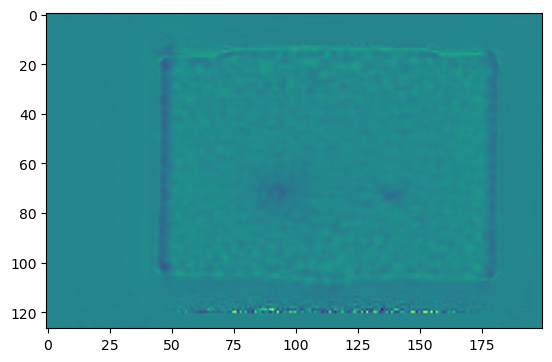

In [169]:

plt.imshow(ss*sDir.as_array()[:,100,:]) #,vmax=2e-4,vmin=-2e-4) #,vmax=0.152)


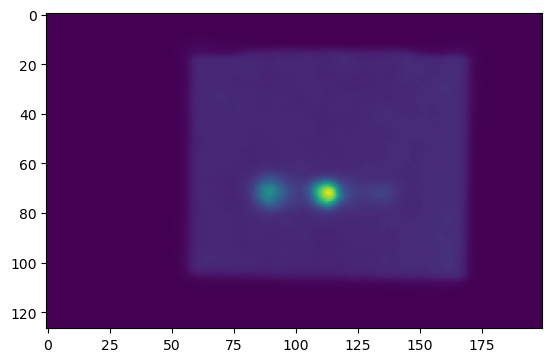

In [171]:

plt.imshow(image.as_array()[:,72,:],vmax=0.122)


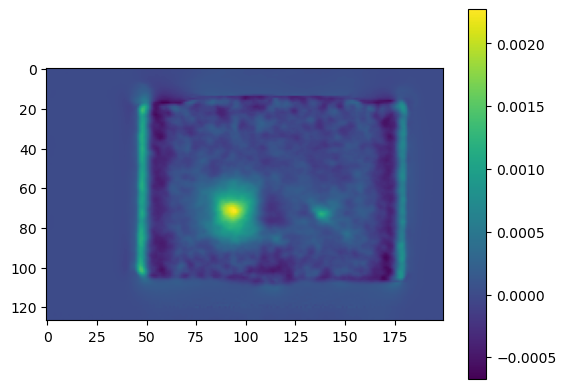

In [175]:
plt.imshow((image.as_array()-recImmCG)[:,100,:])#,vmax=0.120)
plt.colorbar()

# Plot convergence speed

In [258]:
recImmCG =  refImm.as_array()#np.load('refImm.npy')


Text(0, 0.5, 'Difference norm')

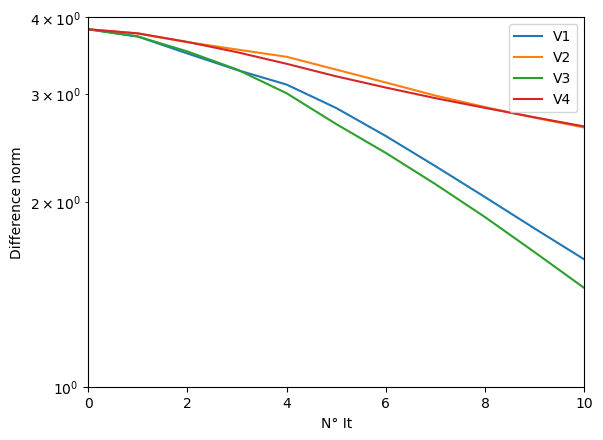

In [275]:

dV = np.sum(np.sum(np.sum((recItV_V1[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_V2[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_V3[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_V4[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)


plt.xlim(0,10)
plt.ylim(1,4)
#plt.plot(np.arange(0,10),10/(np.arange(1,11)))
plt.yscale('log')
plt.legend(['V1','V2','V3','V4'])
plt.xlabel('N° It')
plt.ylabel('Difference norm')
